Successfully loaded data from Reddit, X, and NewsAPI.

 Found 6 corroborated signal keywords: ['high', 'power', 'energy', 'solar', 'big', 'grid']

Generating final corroborated signal chart...


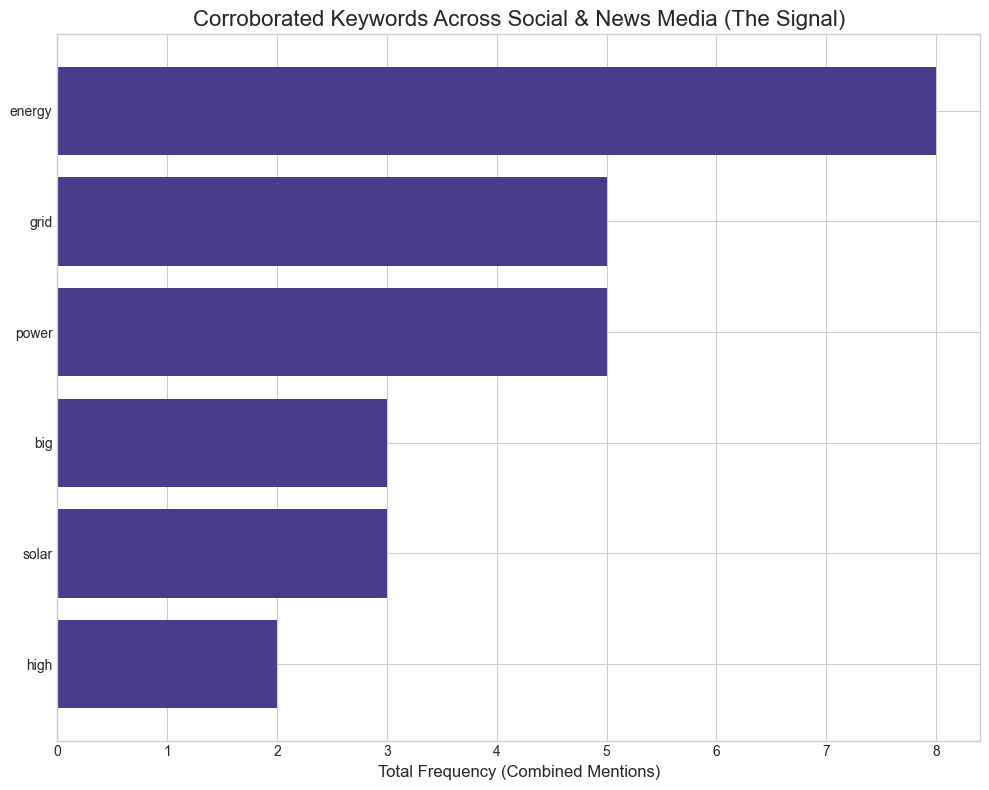


Final chart saved to /figures/final_corroborated_chart.png


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os
import numpy as np

# --- 1. LOAD ALL THREE DATA SOURCES ---
reddit_path = '../data/raw/reddit_titles_filtered.csv'
twitter_path = '../data/raw/twitter_data.csv'
news_path = '../data/raw/news_data.csv'

df_reddit = pd.read_csv(reddit_path)
df_twitter = pd.read_csv(twitter_path)
df_news = pd.read_csv(news_path)

print("Successfully loaded data from Reddit, X, and NewsAPI.")

# --- 2. IDENTIFY THE CORROBORATED SIGNAL ---
social_titles = pd.concat([df_reddit['title'].dropna(), df_twitter['title'].dropna()], ignore_index=True)
official_titles = df_news['title'].dropna()
all_titles = pd.concat([social_titles, official_titles], ignore_index=True)

try:
    # Use one vectorizer on all titles to get a consistent vocabulary
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    vectorizer.fit(all_titles)

    # Create a set of keywords for each source type
    social_keywords = {word for word in vectorizer.get_feature_names_out() if vectorizer.transform(social_titles).toarray().sum(axis=0)[vectorizer.vocabulary_[word]] > 0}
    official_keywords = {word for word in vectorizer.get_feature_names_out() if vectorizer.transform(official_titles).toarray().sum(axis=0)[vectorizer.vocabulary_[word]] > 0}

    # Find the intersection: keywords in BOTH social and official sources
    corroborated_keywords = list(social_keywords.intersection(official_keywords))

    print(f"\n Found {len(corroborated_keywords)} corroborated signal keywords: {corroborated_keywords}")

    # --- 3. VISUALIZE THE FINAL SIGNAL ---
    if corroborated_keywords:
        # Create a new vectorizer focused ONLY on the signal keywords to get their total frequency
        vectorizer_final = CountVectorizer(vocabulary=corroborated_keywords)
        total_counts = vectorizer_final.fit_transform(all_titles)
        summed_counts = np.array(total_counts.sum(axis=0)).flatten()

        final_df = pd.DataFrame({
            'keyword': corroborated_keywords,
            'frequency': summed_counts
        }).sort_values(by='frequency', ascending=True)

        # Generate the Plot
        print("\nGenerating final corroborated signal chart...")
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(final_df['keyword'], final_df['frequency'], color='darkslateblue')
        ax.set_title('Corroborated Keywords Across Social & News Media (The Signal)', fontsize=16)
        ax.set_xlabel('Total Frequency (Combined Mentions)', fontsize=12)
        plt.tight_layout()
        
        plt.savefig('../figures/final_corroborated_chart.png')
        plt.show()
        print("\nFinal chart saved to /figures/final_corroborated_chart.png")
    else:
        print("\nNo corroborated keywords were found to visualize.")
except ValueError as e:
    print(f"\n--- Analysis Error --- \n{e}")